# FIGURE 1

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns; sns.set(color_codes=True)
from msresist.pre_processing import preprocessing, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, CorrCoefFilter, TripsMeanAndStd, FilterByStdev, MergeDfbyMean
from msresist.sequence_analysis import GeneratingKinaseMotifs, FormatName, FormatSeq
import warnings
warnings.simplefilter("ignore")

## 1. Raw Phenotype Data

### 1.1 Cell Viability Measurements

In [2]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

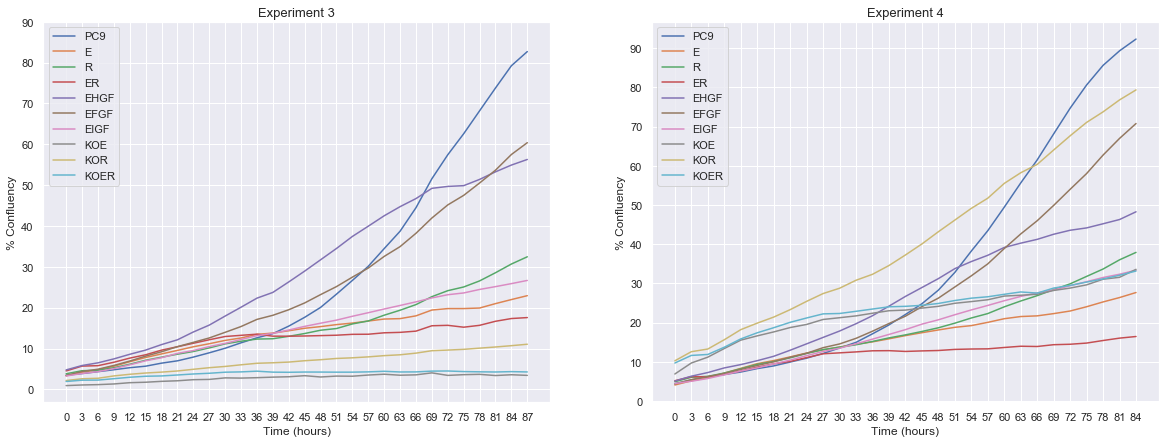

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs[0].set_title("Experiment 3", fontsize=13)
axs[0].plot(Y_cv1.iloc[:, 0], Y_cv1.iloc[:, 1:])
axs[0].set_xticks(Y_cv1.iloc[:, 0])
axs[0].set_yticks(np.arange(0, 100, 10))
axs[0].legend(Y_cv1.columns[1:])
axs[0].set_ylabel("% Confluency")
axs[0].set_xlabel("Time (hours)")
axs[1].set_title("Experiment 4", fontsize=13)
axs[1].plot(Y_cv2.iloc[:, 0], Y_cv2.iloc[:, 1:])
axs[1].set_xticks(Y_cv2.iloc[:, 0])
axs[1].set_yticks(np.arange(0, 100, 10))
axs[1].legend(Y_cv2.columns[1:])
axs[1].set_ylabel("% Confluency")
axs[1].set_xlabel("Time (hours)");

In [4]:
Y_cvE3_0 = Y_cv1[Y_cv1["Elapsed"] == 0].iloc[0, 1:]
Y_cvE3_72 = Y_cv1[Y_cv1["Elapsed"] == 72].iloc[0, 1:]
Y_fcE3 = Y_cv1[Y_cv1["Elapsed"] == 72].iloc[0, 1:]/Y_cv1[Y_cv1["Elapsed"] == 0].iloc[0, 1:]

Y_cvE4_0 = Y_cv2[Y_cv2["Elapsed"] == 0].iloc[0, 1:]
Y_cvE4_72 = Y_cv2[Y_cv2["Elapsed"] == 72].iloc[0, 1:]
Y_fcE4= Y_cv2[Y_cv2["Elapsed"] == 72].iloc[0, 1:]/Y_cv2[Y_cv2["Elapsed"] == 0].iloc[0, 1:]

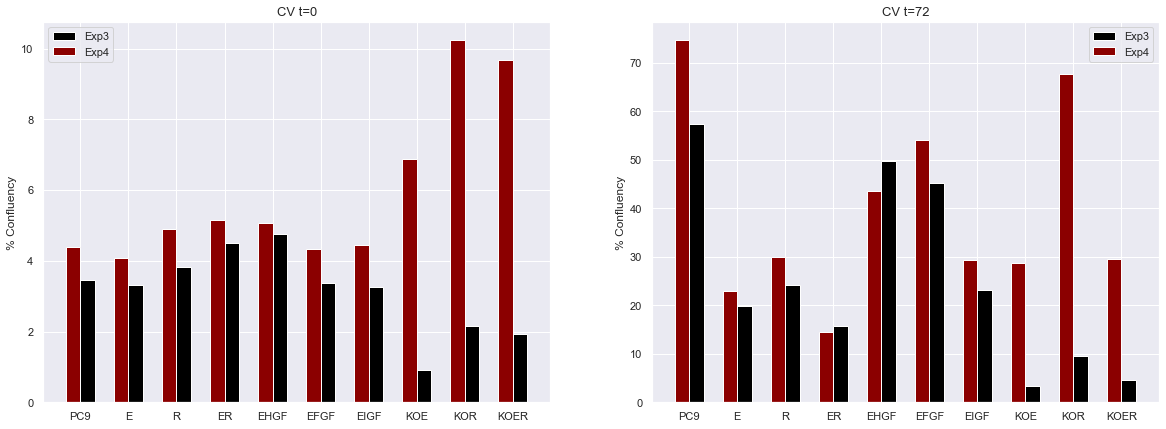

In [5]:
range_ = np.linspace(1, 10, 10)

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs[0].set_title("CV t=0", fontsize=13)
axs[0].set_xticks(np.arange(1,11,1))
axs[0].set_xticklabels(Y_cv1.columns[1:])
axs[0].bar(range_+0.15, Y_cvE3_0, width=0.3, align='center', label='Exp3', color = "black")
axs[0].bar(range_-0.15, Y_cvE4_0, width=0.3, align='center', label='Exp4', color = "darkred")
axs[0].set_ylabel("% Confluency")
axs[0].legend(loc=0)

axs[1].set_title("CV t=72", fontsize=13)
axs[1].set_xticks(np.arange(1,11,1))
axs[1].set_xticklabels(Y_cv1.columns[1:])
axs[1].bar(range_+0.15, Y_cvE3_72, width=0.3, align='center', label='Exp3', color = "black")
axs[1].bar(range_-0.15, Y_cvE4_72, width=0.3, align='center', label='Exp4', color = "darkred")
axs[1].set_ylabel("% Confluency")
axs[1].legend(loc=1)

Experiment 3 Pearson's R:  0.953484716014953 
 p-value:  1.936022266013934e-05
Experiment 4 Pearson's R:  0.8037031342324609 
 p-value:  0.005087300671963526


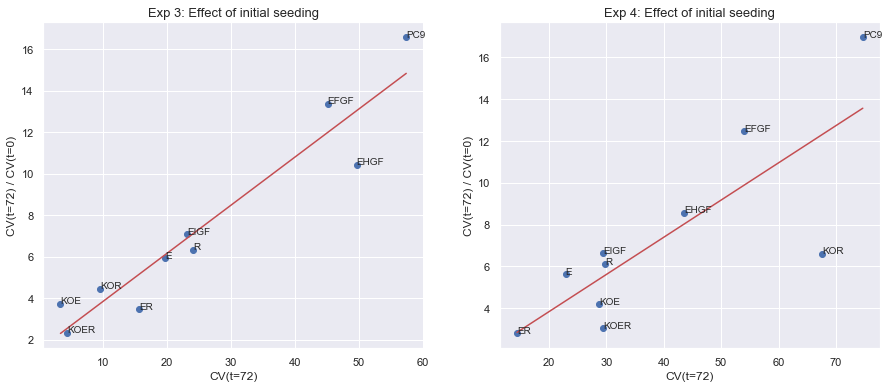

In [6]:
coeff, pval = sp.stats.pearsonr(Y_cvE3_72, Y_fcE3)
print("Experiment 3 Pearson's R: ", coeff, "\n", "p-value: ", pval)
fig, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].set_title("Exp 3: Effect of initial seeding", fontsize=13)
axs[0].scatter(Y_cvE3_72, Y_fcE3)
axs[0].plot(np.unique(Y_cvE3_72), np.poly1d(np.polyfit(Y_cvE3_72, Y_fcE3, 1))(np.unique(Y_cvE3_72)), color = "r")
for j, txt in enumerate(list(Y_cv1.columns[1:])):
    axs[0].annotate(txt, (Y_cvE3_72[j], Y_fcE3[j]))
axs[0].set_ylabel("CV(t=72) / CV(t=0)")
axs[0].set_xlabel("CV(t=72)")

coeff2, pval2 = sp.stats.pearsonr(Y_cvE4_72, Y_fcE4)
print("Experiment 4 Pearson's R: ", coeff2, "\n", "p-value: ", pval2)
axs[1].set_title("Exp 4: Effect of initial seeding", fontsize=13)
axs[1].scatter(Y_cvE4_72, Y_fcE4)
axs[1].plot(np.unique(Y_cvE4_72), np.poly1d(np.polyfit(Y_cvE4_72, Y_fcE4, 1))(np.unique(Y_cvE4_72)), color = "r")
for j, txt in enumerate(list(Y_cv2.columns[1:])):
    axs[1].annotate(txt, (Y_cvE4_72[j], Y_fcE4[j]))
axs[1].set_ylabel("CV(t=72) / CV(t=0)")
axs[1].set_xlabel("CV(t=72)");

#### Experiment 3 @ 72h:

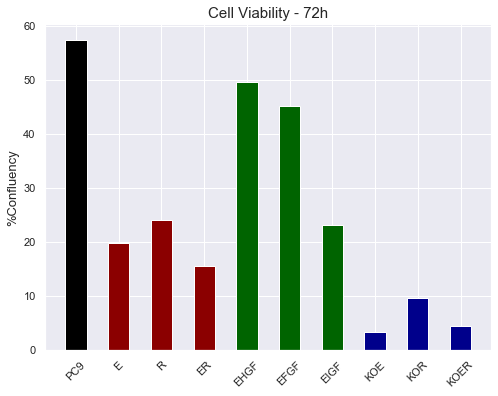

In [7]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
plt.bar(np.linspace(1,10,10)-1, Y_cvE3_72, width=0.5, align='center', color=['black', 'darkred', 'darkred', 'darkred', 'darkgreen', 'darkgreen', 'darkgreen', 'darkblue', 'darkblue', 'darkblue'])
plt.xticks(np.arange(10), (Y_cv1.columns[1:]), rotation=45)
plt.title("Cell Viability - 72h", fontsize=15)
plt.ylabel("%Confluency", fontsize = 13);

## 2. Raw Phosphorylation Measurements

In [8]:
A_r = pd.read_csv('./msresist/data/Raw/20180817_JG_AM_TMT10plex_R1_psms_raw.csv', header=0)
B_r = pd.read_csv('./msresist/data/Raw/20190214_JG_AM_PC9_AXL_TMT10_AC28_R2_PSMs_raw.csv', header=0)
C_r = pd.read_csv('./msresist/data/Raw/CombinedBR3_TR1&2_raw.csv', header=0)
header = A_r.columns

ABC_mc = preprocessing(A_r, B_r, C_r, motifs=True, Vfilter=True, FCfilter=True, log2T=False)

### 2.1 Clustergram

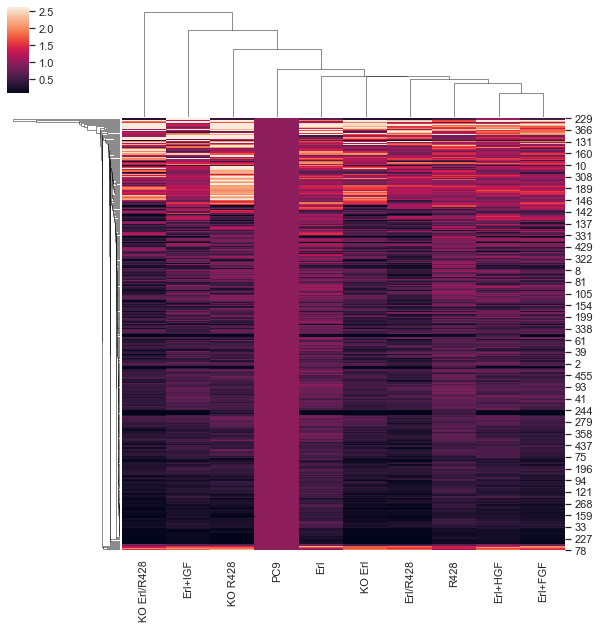

In [9]:
g = sns.clustermap(ABC_mc.iloc[:, 2:], method = "single", robust=True)
g;

Clustergram Table:

In [10]:
p = g.dendrogram_row.reordered_ind
hm_prots = []
x = list(map(lambda v: hm_prots.append(ABC_mc.iloc[v, :]), p))
hm_prots = pd.DataFrame(hm_prots)

### 2.2 Pearson's heatmap 

Correlation heatmap with peptides re-ordered as obtained by Clustergram:

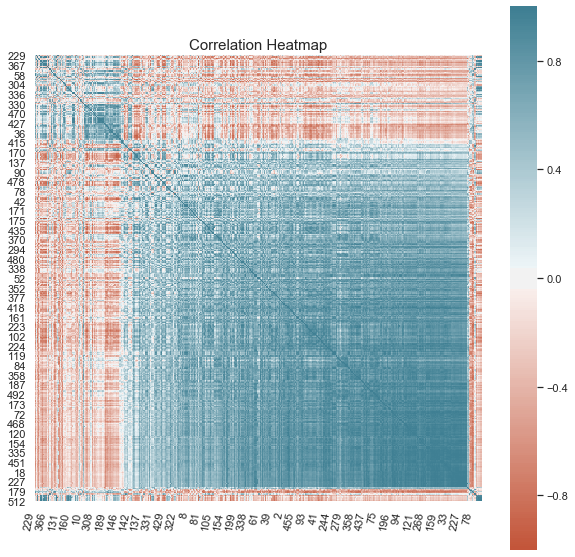

In [11]:
corr = ABC_mc.iloc[p, 2:].T.corr(method='pearson')
fig, ax = plt.subplots(figsize = (10,10))
ax = sns.heatmap(corr,  vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80, horizontalalignment='right')
ax.set_title("Correlation Heatmap", fontsize=15);

### 2.3 Phosphorylation Status of Bypass RTKs

Look at the fold-change of canonical phosphorylation sites of bypass RTKs across conditions:

In [12]:
ABC = FoldChangeToControl(pd.concat([A_r, B_r, C_r]))

In [13]:
EGFR = ABC[ABC["peptide-phosphosite"].str.contains("gSHQISLDNPDyQQDFFPk-1")].mean()
IGFR = ABC[ABC["peptide-phosphosite"].str.contains("dIYETDYyR-1")].iloc[:, 2:].mean()
MET = ABC[ABC["peptide-phosphosite"].str.contains("dMYDkEyYSVHNk-1")].iloc[:, 2:].mean()
AXL = ABC[ABC["peptide-phosphosite"].str.contains("YNGDyYR-1")].iloc[:, 2:].mean()

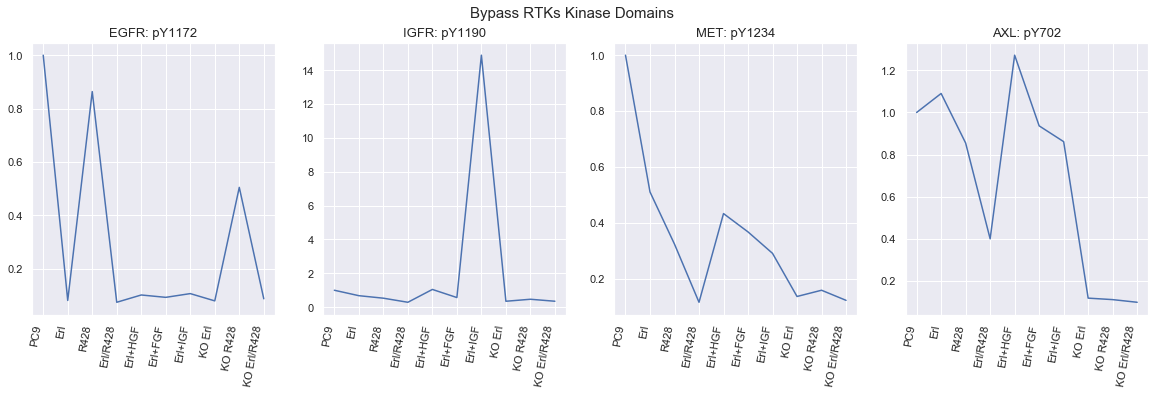

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].set_title("EGFR: pY1172", fontsize=13)
axs[0].plot(EGFR)
axs[0].set_xticklabels(header[2:], rotation=80, horizontalalignment='right')
axs[1].set_title("IGFR: pY1190", fontsize=13)
axs[1].plot(IGFR)
axs[1].set_xticklabels(header[2:], rotation=80, horizontalalignment='right')
axs[2].set_title("MET: pY1234", fontsize=13)
axs[2].plot(MET)
axs[2].set_xticklabels(header[2:], rotation=80, horizontalalignment='right')
axs[3].set_title("AXL: pY702", fontsize=13)
axs[3].plot(AXL)
axs[3].set_xticklabels(header[2:], rotation=80, horizontalalignment='right')
fig.suptitle('Bypass RTKs Kinase Domains', fontsize=15);

## 3. Variability across Replicates


Concatenated Raw Data:

In [15]:
ABC = FoldChangeToControl(pd.concat([A_r, B_r, C_r]))
ABC["Master Protein Descriptions"] = FormatName(ABC)

In [16]:
dups = pd.pivot_table(ABC, index=['Master Protein Descriptions', 'peptide-phosphosite'], aggfunc="size").sort_values()
dups_counter = {i: list(dups).count(i) for i in list(dups)}
dups_counter

{1: 620, 2: 246, 3: 128}

In [17]:
NonRecPeptides, CorrCoefPeptides, StdPeptides = MapOverlappingPeptides(ABC)

### 3.1 Grouping by Raw Sequences:

Duplicates:

In [18]:
DupsTable = BuildMatrix(CorrCoefPeptides, ABC)
# DupsTable = CorrCoefFilter(DupsTable)
DupsTable_drop = DupsTable.drop_duplicates(["peptide-phosphosite", "Master Protein Descriptions"])
assert(DupsTable.shape[0]/2 == DupsTable_drop.shape[0])

Triplicates:

In [19]:
StdPeptides = BuildMatrix(StdPeptides, ABC)
TripsTable = TripsMeanAndStd(StdPeptides, A_r.columns)
Stds = TripsTable.iloc[:, TripsTable.columns.get_level_values(1) == 'std']
# Xidx = np.all(Stds.values <= 0.4, axis=1)
# Stds = Stds.iloc[Xidx, :]
Std_mean = Stds.iloc[:, 1:].mean(axis=1)

Mean of Correlation Coefficients:  0.5216231686519708
Mean of Standard Deviations:  0.28687444896807446


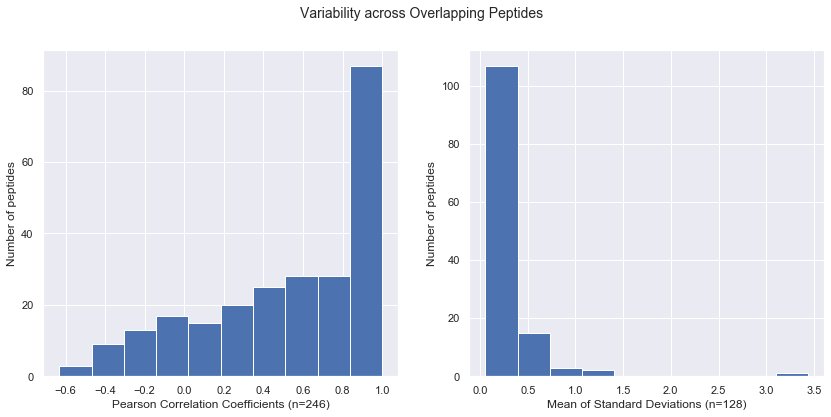

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))
n_bins = 10
print("Mean of Correlation Coefficients: ", np.mean(DupsTable_drop.iloc[:, 12]))
print("Mean of Standard Deviations: ", np.mean(Std_mean))
axs[0].hist(DupsTable_drop.iloc[:, 12], bins=n_bins)
axs[0].set_ylabel("Number of peptides", fontsize=12)
axs[0].set_xlabel("Pearson Correlation Coefficients (n=246)", fontsize=12)
axs[1].hist(Std_mean, bins=n_bins)
axs[1].set_xlabel("Mean of Standard Deviations (n=128)", fontsize=12)
axs[1].set_ylabel("Number of peptides", fontsize=12)
fig.suptitle('Variability across Overlapping Peptides', fontsize=14);

### 3.2 Re-implementation grouping by pY-centered motifs:

In [21]:
directory = "./msresist/data/Sequence_analysis/"
names, motifs = GeneratingKinaseMotifs(directory + "FaFile.fa", FormatName(ABC), FormatSeq(ABC), directory + "MatchedFaFile.fa", directory + "proteome_uniprot.fa")
ABC['peptide-phosphosite'] = motifs
ABC['Master Protein Descriptions'] = names

In [22]:
dups = pd.pivot_table(ABC, index=['Master Protein Descriptions', 'peptide-phosphosite'], aggfunc="size").sort_values()
dups_counter = {i: list(dups).count(i) for i in list(dups)}
dups_counter

{1: 516, 2: 228, 3: 106, 4: 24, 5: 11, 6: 8, 7: 1}

In [23]:
NonRecPeptides, CorrCoefPeptides, StdPeptides = MapOverlappingPeptides(ABC)

Duplicates:

In [24]:
DupsTable = BuildMatrix(CorrCoefPeptides, ABC)
# DupsTable = CorrCoefFilter(DupsTable)
DupsTable_drop = DupsTable.drop_duplicates(["peptide-phosphosite", "Master Protein Descriptions"])
assert(DupsTable.shape[0]/2 == DupsTable_drop.shape[0])

Triplicates:

In [25]:
StdPeptides = BuildMatrix(StdPeptides, ABC)
TripsTable = TripsMeanAndStd(StdPeptides, A_r.columns)
Stds = TripsTable.iloc[:, TripsTable.columns.get_level_values(1) == 'std']
# Xidx = np.all(Stds.values <= 0.4, axis=1)
# Stds = Stds.iloc[Xidx, :]
Std_mean = Stds.iloc[:, 1:].mean(axis=1)

Mean of Correlation Coefficients:  0.5212571376085484
Mean of Standard Deviations:  0.28620192258339944


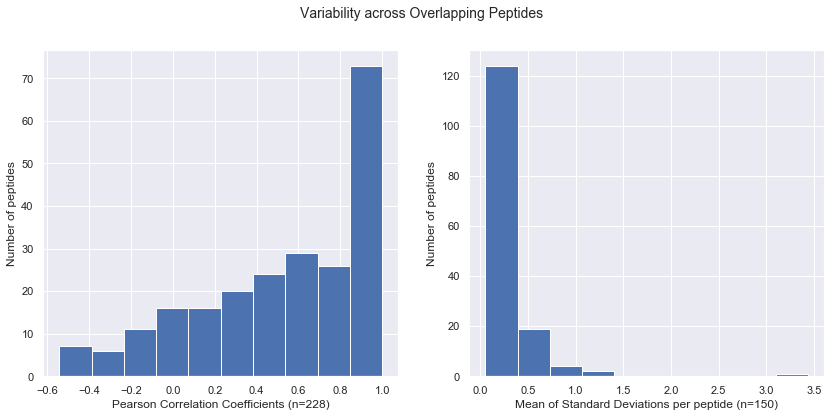

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))
n_bins = 10
print("Mean of Correlation Coefficients: ", np.mean(DupsTable_drop.iloc[:, 12]))
print("Mean of Standard Deviations: ", np.mean(Std_mean))
axs[0].hist(DupsTable_drop.iloc[:, 12], bins=n_bins)
axs[0].set_ylabel("Number of peptides", fontsize=12)
axs[0].set_xlabel("Pearson Correlation Coefficients (n=228)", fontsize=12)
axs[1].hist(Std_mean, bins=n_bins)
axs[1].set_xlabel("Mean of Standard Deviations per peptide (n=150)", fontsize=12)
axs[1].set_ylabel("Number of peptides", fontsize=12)
fig.suptitle('Variability across Overlapping Peptides', fontsize=14);